In [15]:
from sklearn.datasets import fetch_mldata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# 分类
from sklearn.linear_model import SGDClassifier
# 模型评估
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
# multiclass
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
# 多标签分类
from sklearn.neighbors import KNeighborsClassifier
# from mnist import MNIST
from six.moves import urllib
from sklearn.datasets import fetch_mldata
from scipy.io import loadmat

## MNIST数据集

In [5]:
mnist = fetch_mldata('MNIST original', transpose_data=True, data_home='files')

TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

In [10]:
# 参考issues代码，成功加载数据集
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


In [11]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

## 绘图

<function matplotlib.pyplot.show(*args, **kw)>

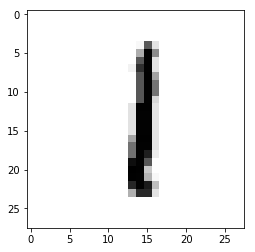

In [16]:
# 随机显示一张图片
pick_one = np.random.randint(0, X.shape[0])
some_digit = X[pick_one]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = "nearest")
plt.show

In [17]:
y[pick_one]

1.0

In [18]:
# 画出100张数字图片
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

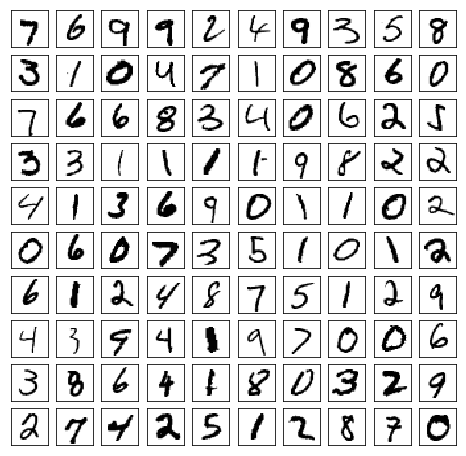

In [19]:
plot_100_image(X)

In [20]:
# 训练集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


shuffle_index = np.random.permutation(60000) # 随机生成一个60000维的序列，成为索引
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练二维分类器

先试着识别一个数字，使用随机梯度下降（SGD）分类器，优势是：能够有效处理大型数据，一次一个实例。

In [26]:
y_train_5 = (y_train == 5) # True for 5, False for other digits
y_test_5 = (y_test == 5)

print(y_train_5.shape)

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

(60000,)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False)

5.0


array([False])

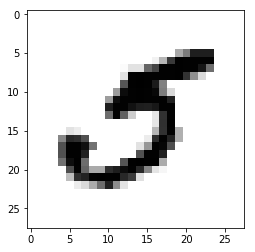

In [30]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = "nearest")
plt.show

print(y[36000])
# sgd_clf.predict(some_digit) # 需要是一个列表
sgd_clf.predict([some_digit])

竟然预测错了。。

## 评价模型性能

比回归器评价更加困难，主要方法有**交叉验证**、**混淆矩阵**、**ROC曲线**等方法。

### 交叉验证测量精度

In [31]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9214 , 0.9252 , 0.94395])

发现这个分类器的效果在92%以上都能识别出来！

使用其他分类器测试一下。用一个分类器分成非5。

In [32]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.9122 , 0.9105 , 0.90625])

有90%的准确率猜测这张图片是非5！由于数据集中10%是5，所以猜测这个图片是非5，那有90%以上的概率猜测正确！

显然，只使用准确率无法成为衡量分类器的首要性能指标。

### 混淆矩阵

In [33]:
# 返回的不是分数，而是每个折叠的预测
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# 混淆矩阵
confusion_matrix(y_train_5, y_train_pred)

array([[51889,  2690],
       [ 1499,  3922]], dtype=int64)

In [35]:
# 精度和召回率
precision_score(y_train_5, y_train_pred)

0.5931639443436176

In [36]:
recall_score(y_train_5, y_train_pred)

0.7234827522597307

In [37]:
# F1分数
f1_score(y_train_5, y_train_pred)

0.6518740131305576

### 精度/召回率权衡

有时候我们更关心某个指标，比如召回率，小偷预测时，我们当然想要提高召回率，把小偷最大限度地预测出来。而有时候又希望有低召回率，比如筛选儿童健康视频，我们希望筛选出来的都是安全的，精度高。

做不到鱼和熊掌兼得，那就需要权衡这两个指标。

设置阈值时，使用预测的决策分数，用decision_function()函数。

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-108659.42327569])

In [41]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [42]:
# 提高阈值
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [43]:
# 如何设置阈值
# 计算每个实例的决策分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = "decision_function")

# 计算阈值下的精度和召回率
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


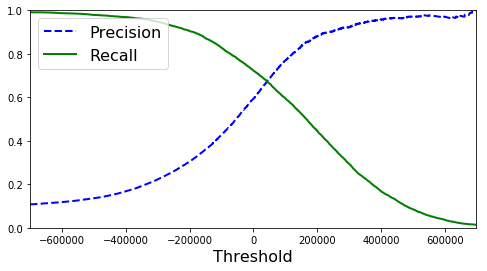

In [45]:
# 绘制曲线
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

通过绘制的图像，假设我们需要找到精度90%以上的阈值，可以看到阈值设置在70000，我们看下精度。



In [47]:
(y_train_pred == (y_scores > 0)).all()
y_train_pred_90 = (y_scores > 70000)


precision_score(y_train_5, y_train_pred_90)


0.7205267558528428

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.6358605423353625

还有一种找到权衡精度/召回率的方法，就是绘制精度-召回率曲线。

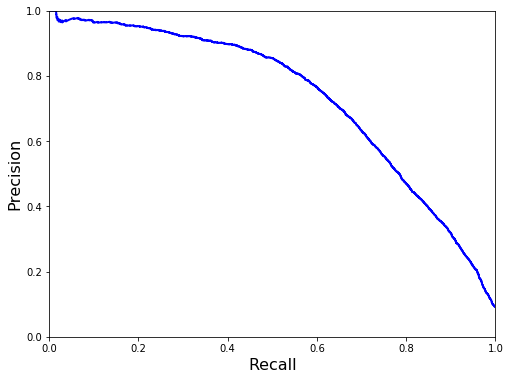

In [49]:

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# save_fig("precision_vs_recall_plot")
plt.show()

从图中可以看出，80%之后的召回率往右，精度在下降，尽量在这个陡降之前选择一个权衡——比如召回率60%。

### ROC曲线

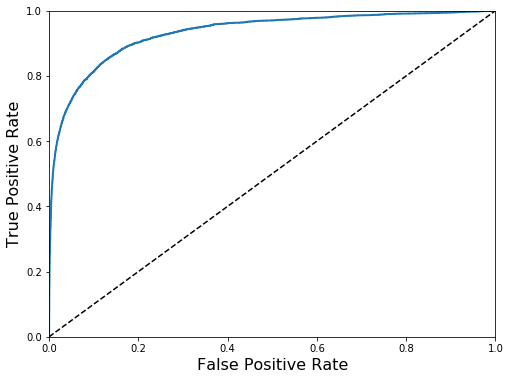

In [51]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

### ROC AUC

ROC曲线下面积为AUC。

In [52]:
roc_auc_score(y_train_5, y_scores)

0.9327486211733336

## 模型对比

我们使用随机森林模型，与上面的SGD模型进行比较。通过AUC和ROC来比较。

值得注意的是，随机森林中没有decision_function()函数，使用dict_proba()绘制。

In [55]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")

# 使用正类的概率作为分数值
y_score_forest = y_probas_forest[:, -1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)



C:\Users\Administrator.XuanJi-PC\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


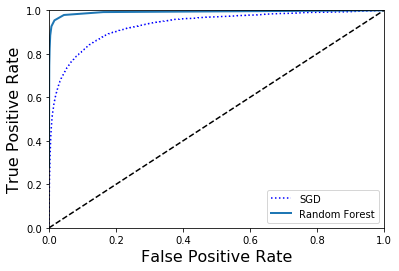

In [57]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "bottom right")
plt.show()

In [58]:
roc_auc_score(y_train_5, y_score_forest)

0.9924181800055476

我们可以看到，随机森林分类器的AUC要比SGD高，并且ROC也表现更佳。

## 多类别分类器